# Introduction
This colab worksheet provides a starting point for the computer vision assignment. 

# Data Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
# Load the data using np.load
data = np.load('/content/drive/My Drive/CV_Assignment/training_images.npz', allow_pickle=True)
test = np.load('/content/drive/My Drive/CV_Assignment/test_images.npz', allow_pickle=True)
example = np.load('/content/drive/My Drive/CV_Assignment/examples.npz', allow_pickle=True)
# Extract the images
train_images = data['images']
test_images = test['images']
examples = example['images']
# and the data points
train_points = data['points']

# Data Visualisation
Here's an example of how to display the images and their points

(2811, 236, 236, 3) [[[ 42.5003016   89.36088652]
  [ 56.00176855 151.18841025]
  [ 91.46640371 203.33634986]
  ...
  [123.04641844 165.81829999]
  [148.05130887 163.10638616]
  [123.62994994 171.07008176]]

 [[ 32.4640478   92.52442898]
  [ 58.59720782 166.32695059]
  [108.21250285 212.33475237]
  ...
  [121.08760074 173.00466552]
  [144.05659942 175.51128454]
  [121.28968208 176.23796785]]

 [[ 58.31923824 102.64368569]
  [ 54.99481145 156.94397219]
  [ 79.46904617 208.44019324]
  ...
  [103.34504174 156.95847548]
  [145.03332151 157.50151496]
  [103.6296584  169.93157107]]

 ...

 [[ 56.10828357  95.25131432]
  [ 59.28305106 153.22381369]
  [ 81.44655392 201.12537561]
  ...
  [109.63229402 166.98480974]
  [143.16406226 162.06440163]
  [109.63229402 166.98480974]]

 [[ 12.05053432  83.90541796]
  [ 11.99407976 146.68515592]
  [ 58.78998365 202.85882626]
  ...
  [124.19093614 165.77082668]
  [134.14407265 173.40932497]
  [124.19093614 165.77082668]]

 [[ -1.35715296  59.0255438 ]
  [ 

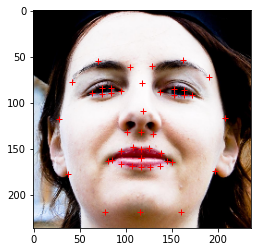

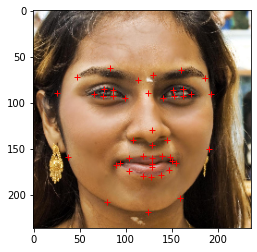

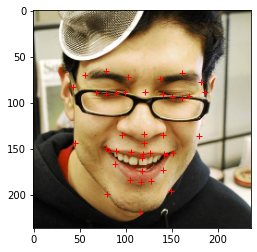

In [ ]:
print(train_images.shape, train_points)
def visualise_pts(train_images, pts):
  plt.imshow(train_images)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

for i in range(3):
  idx = np.random.randint(0, train_images.shape[0])
  visualise_pts(train_images[idx, ...], train_points[idx, ...])

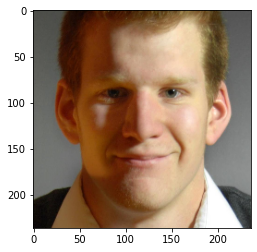

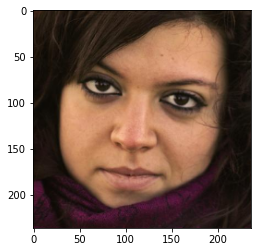

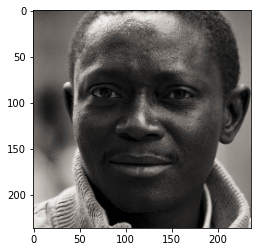

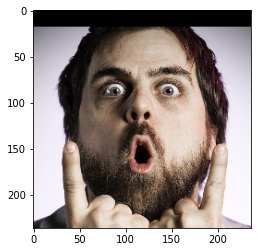

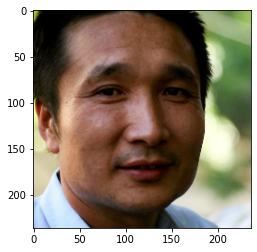

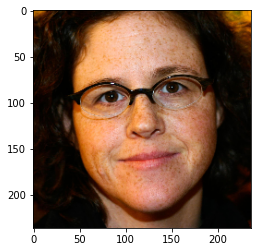

In [ ]:
for i in range(6):
  plt.imshow(examples[i])
  plt.show()

# Calculating Prediction Error and exporting results

In [ ]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))


In [ ]:
def save_as_csv(points, location = '.'):
  """
  Save the points out as a .csv file
  :param points: numpy array of shape (no_image, no_points, 2) to be saved
  :param location: Directory to save results.csv in. Default to current working directory
  """
  np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')


# Basic Regression Pipeline
Take a look at the FML lab on [linear regression](https://colab.research.google.com/drive/1P3gvarGJmrqatZ9ielZnT8_5yRoTHJ-b) to see a simple method for predicting real valued numbers.

# 5.1    Face Alignment

In [3]:
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

keras = tf.keras
layers = tf.keras.layers

from IPython.display import Image

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, History
from keras.optimizers import Adam
from keras.layers import ELU
from keras.layers.normalization import BatchNormalization

from keras.models import load_model

In [4]:
def visualise_pts(img, pts):
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

In [5]:
def align_face(image, pts):
    # get  landmarks of left and right eye
    left_eye_left = pts[18]
    left_eye_right = pts[21]
    right_eye_left = pts[24]
    right_eye_right = pts[27]

    # calculate the mean point of landmarks of left and right eye
    left_eye_center = [np.mean([left_eye_left[0],left_eye_right[0]]),np.mean([left_eye_left[1],left_eye_right[1]])]
    right_eye_center = [np.mean([right_eye_left[0],right_eye_right[0]]),np.mean([right_eye_left[1],right_eye_right[1]])]

    # compute the angle between the eye centroids
    dy = right_eye_center[1] - left_eye_center[1]
    dx = right_eye_center[0] - left_eye_center[0]

    # compute angle between the line of 2 centeroids and the horizontal line
    angle = math.atan2(dy, dx) * 180. / math.pi
    # calculate the center of 2 eyes
    eye_center = ((left_eye_center[0] + right_eye_center[0]) // 2,
                  (left_eye_center[1] + right_eye_center[1]) // 2)
    # at the eye_center, rotate the image by the angle
    rotate_matrix = cv2.getRotationMatrix2D(eye_center, angle, scale=1)
    rotated_img = cv2.warpAffine(image, rotate_matrix, (image.shape[1], image.shape[0]))
    return rotated_img, eye_center, angle

def rotate(origin, point, angle, row):
    """ rotate coordinates in image coordinate system
    :param origin: tuple of coordinates,the rotation center
    :param point: tuple of coordinates, points to rotate
    :param angle: degrees of rotation
    :param row: row size of the image
    :return: rotated coordinates of point
    """
    x1, y1 = point
    x2, y2 = origin
    y1 = row - y1
    y2 = row - y2
    angle = math.radians(angle)
    x = x2 + math.cos(angle) * (x1 - x2) - math.sin(angle) * (y1 - y2)
    y = y2 + math.sin(angle) * (x1 - x2) + math.cos(angle) * (y1 - y2)
    y = row - y
    return [x, y]
    
def rotate_landmarks(landmarks, eye_center, angle, row):
    """ rotate landmarks to fit the aligned face
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :param eye_center: tuple of coordinates for eye center
    :param angle: degrees of rotation
    :param row: row size of the image
    :return: rotated_landmarks with the same structure with landmarks, but different values
    """
    rotated_landmarks = []
    for landmark in pts:
      rotated_landmark = rotate(origin=eye_center, point=landmark, angle=angle, row=image.shape[0])
      rotated_landmarks.append(rotated_landmark)
      rotated_pts = np.array(rotated_landmarks)
    return rotated_pts

### feature descriptor

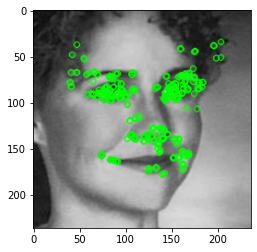

(<matplotlib.image.AxesImage at 0x7f2776fb4e50>, None)

In [ ]:
import cv2
img = Gray_image # query Image
img= img.astype('uint8')
orb = cv2.ORB_create()        # Initiate SIFT detector

# find the keypoints with ORB
kp = orb.detect(img,None)

# compute the descriptors with ORB
kp, des = orb.compute(img, kp)
img2 = cv2.drawKeypoints(img,kp,outImage = None,color=(0,255,0), flags=0)
plt.imshow(img2),plt.show()

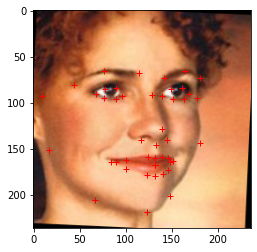

In [ ]:
visualise_pts(rotated_img, rotated_pts)

In [ ]:
rotated_img, eye_center, angle = align_face(image, pts)
rotated_pts = rotate_landmarks(pts,eye_center, angle, image.shape[0])

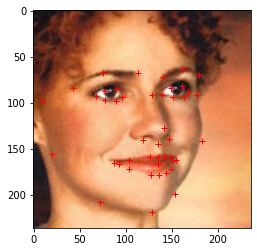

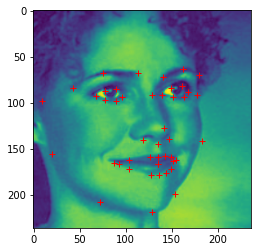

In [ ]:
image=train_images[1140]
Gray_image=Grayscale_train_images[1140]
pts=train_points[1140]
visualise_pts(image, pts)
visualise_pts(Gray_image, pts)


### preprocessing

In [ ]:
#convert images to grayscale
Grayscale_train_images = np.zeros(train_images.shape[:-1])
for i in range(train_images.shape[0]): 
    Grayscale_train_images[i] = cv2.cvtColor(train_images[i], cv2.COLOR_BGR2GRAY) 

In [ ]:
print('Orianl image data: ' + str(train_images.shape))
print('Gray image data: ' + str(Grayscale_train_images.shape))
print('Orinal points data: ' + str(train_points.shape))
print('Test image data: ' + str(test_images.shape))

Orianl image data: (2811, 236, 236, 3)
Gray image data: (2811, 236, 236)
Orinal points data: (2811, 46, 2)
Test image data: (554, 236, 236, 3)


In [ ]:
Grayscale_train_images_reshape = Grayscale_train_images.reshape(Grayscale_train_images.shape[0],236,236,1)

In [ ]:
train_points_reshape=train_points.reshape(train_points.shape[0],-1)

In [ ]:
print('Gray image data: ' + str(Grayscale_train_images_reshape.shape))
print('reshape points data: ' + str(train_points_reshape.shape))

Gray image data: (2811, 236, 236, 1)
reshape points data: (2811, 92)


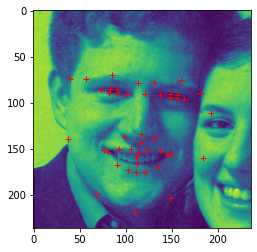

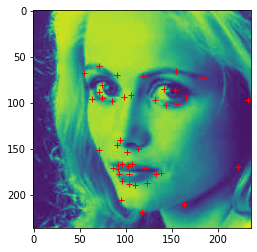

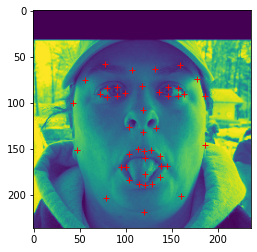

In [ ]:
for i in range(3):
  idx = np.random.randint(0, train_images.shape[0])
  visualise_pts(Grayscale_train_images[idx, ...], train_points[idx, ...])

### failed test

In [ ]:

# model checkpoint 
checkpoint = ModelCheckpoint('/content/drive/My Drive/CV_Assignment/best_weights.h5', verbose=1, save_best_only=True)
hist = History()
# model architecture
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(236, 236, 1)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(92))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 234, 234, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 117, 117, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 115, 115, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 57, 57, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 55, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 128)       7

In [ ]:
# training the model
hist = model.fit(Grayscale_train_images_reshape,train_points_reshape, validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],shuffle=True, epochs=20, verbose=1)
# save the model weights
model.save_weights('/content/drive/My Drive/CV_Assignment/weights.h5')
# save the model
model.save('/content/drive/My Drive/CV_Assignment/model.h5')

Epoch 1/20
36/36 [==============================] - 115s 3s/step - loss: 4934.9128 - accuracy: 0.1427 - val_loss: 1178.8425 - val_accuracy: 0.8028

Epoch 00001: val_loss improved from inf to 1178.84253, saving model to /content/drive/My Drive/CV_Assignment/best_weights.h5
Epoch 2/20
36/36 [==============================] - 115s 3s/step - loss: 1206.0747 - accuracy: 0.3883 - val_loss: 759.8422 - val_accuracy: 0.8028

Epoch 00002: val_loss improved from 1178.84253 to 759.84216, saving model to /content/drive/My Drive/CV_Assignment/best_weights.h5
Epoch 3/20
36/36 [==============================] - 115s 3s/step - loss: 1034.9661 - accuracy: 0.4190 - val_loss: 1291.1190 - val_accuracy: 0.8028

Epoch 00003: val_loss did not improve from 759.84216
Epoch 4/20
36/36 [==============================] - 114s 3s/step - loss: 958.9423 - accuracy: 0.4651 - val_loss: 1057.8582 - val_accuracy: 0.8028

Epoch 00004: val_loss did not improve from 759.84216
Epoch 5/20
36/36 [==============================

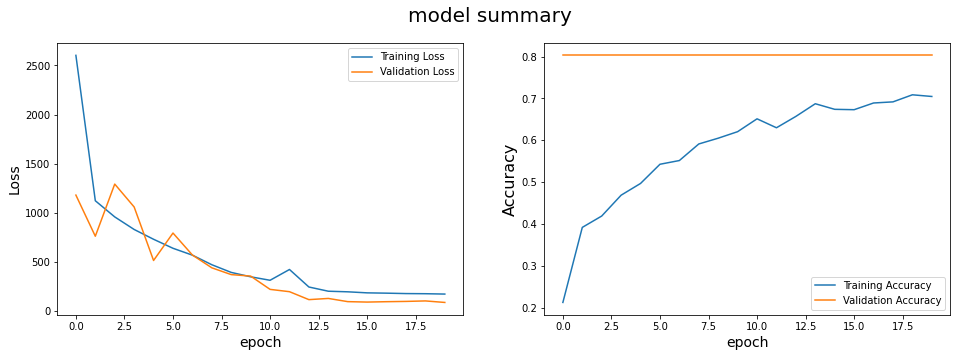

In [ ]:
# plot summary
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.suptitle('model summary', fontsize=20)
# summarize history for loss
plt.xlabel('epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

# summarize history for accuracy
plt.subplot(1, 2, 2)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

### cnn model

In [ ]:
# Draw the network diagram
keras.utils.plot_model(model, "conv_model.png", show_shapes=True)
Image(retina=True, filename='conv_model.png')

In [6]:
# model checkpoint 
checkpoint = ModelCheckpoint('/content/drive/My Drive/CV_Assignment/best_weights2.h5', verbose=1, save_best_only=True)
hist = History()
# model architecture
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(32,(5,5),input_shape=(236,236,1),data_format="channels_last"),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPool2D((2,2),2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),         # Dropout
    
    tf.keras.layers.Conv2D(64,(3,3)),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPool2D((2,2),2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),         # Dropout
   
    tf.keras.layers.Conv2D(128,(3,3)),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPool2D((2,2),2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),         # Dropout
    
    tf.keras.layers.Conv2D(256,(3,3)),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPool2D((2,2),2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),         # Dropout
 
    tf.keras.layers.Conv2D(512,(1,1)),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPool2D((2,2),2),
    tf.keras.layers.BatchNormalization(),
  
    tf.keras.layers.Flatten(),
   
 
    tf.keras.layers.Dense(1024),
    tf.keras.layers.ELU(),
    
    tf.keras.layers.Dropout(0.5), # Dropout
 
    tf.keras.layers.Dense(1024),
    tf.keras.layers.ELU(),
   

   
    tf.keras.layers.Dense(92,activation="linear")
    
    
    ])

model.summary()
opt = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 232, 232, 32)      832       
_________________________________________________________________
elu (ELU)                    (None, 232, 232, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 116, 116, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 116, 116, 32)      128       
_________________________________________________________________
dropout (Dropout)            (None, 116, 116, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 114, 114, 64)      18496     
_________________________________________________________________
elu_1 (ELU)                  (None, 114, 114, 64)      0

In [ ]:
hist = model.fit(Grayscale_train_images_reshape,train_points_reshape, validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],shuffle=True, epochs=40, verbose=1)

Epoch 1/40
36/36 [==============================] - 332s 9s/step - loss: 6111.9564 - accuracy: 0.3520 - val_loss: 4133.4624 - val_accuracy: 0.7318

Epoch 00001: val_loss improved from inf to 4133.46240, saving model to /content/drive/My Drive/CV_Assignment/best_weights2.h5
Epoch 2/40
36/36 [==============================] - 327s 9s/step - loss: 440.8132 - accuracy: 0.6114 - val_loss: 876.0480 - val_accuracy: 0.7993

Epoch 00002: val_loss improved from 4133.46240 to 876.04797, saving model to /content/drive/My Drive/CV_Assignment/best_weights2.h5
Epoch 3/40
36/36 [==============================] - 332s 9s/step - loss: 316.0929 - accuracy: 0.6114 - val_loss: 224.6429 - val_accuracy: 0.8046

Epoch 00003: val_loss improved from 876.04797 to 224.64293, saving model to /content/drive/My Drive/CV_Assignment/best_weights2.h5
Epoch 4/40
36/36 [==============================] - 326s 9s/step - loss: 209.2768 - accuracy: 0.6674 - val_loss: 169.3367 - val_accuracy: 0.8206

Epoch 00004: val_loss imp

In [ ]:
# save the model weights
model.save_weights('/content/drive/My Drive/CV_Assignment/weights.h5')
# save the model
model.save('/content/drive/My Drive/CV_Assignment/model.h5')

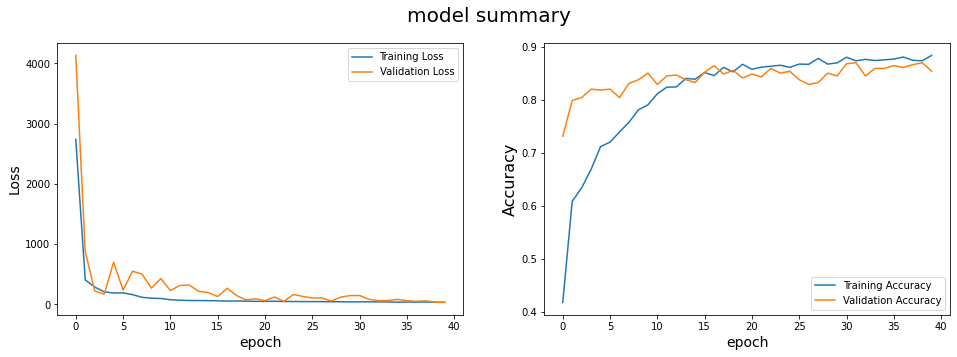

In [ ]:
# plot summary
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.suptitle('model summary', fontsize=20)
# summarize history for loss
plt.xlabel('epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

# summarize history for accuracy
plt.subplot(1, 2, 2)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

## test data

In [7]:
# load already saved model weights if it exists
model.load_weights('/content/drive/My Drive/CV_Assignment/best_weights2.h5')

In [ ]:
#convert images to grayscale
Grayscale_test_images = np.zeros(test_images.shape[:-1])
for i in range(test_images.shape[0]): 
    Grayscale_test_images[i] = cv2.cvtColor(test_images[i], cv2.COLOR_BGR2GRAY) 

In [ ]:
# make test images keypoints prediction
test_points = model.predict(Grayscale_test_images.reshape(Grayscale_test_images.shape[0], 236, 236, 1))

In [ ]:
test_points=test_points.reshape(test_points.shape[0],46,2)

500


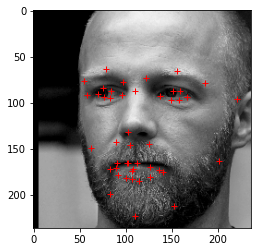

2


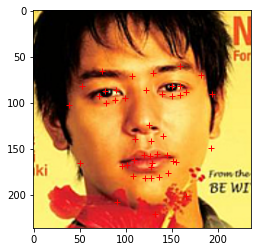

151


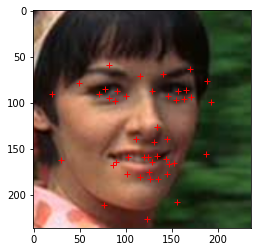

204


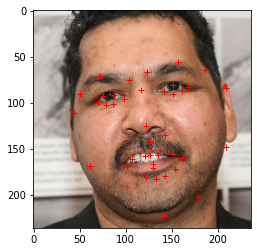

419


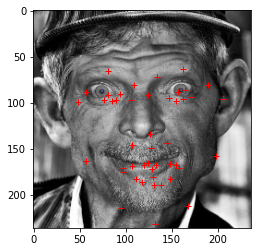

242


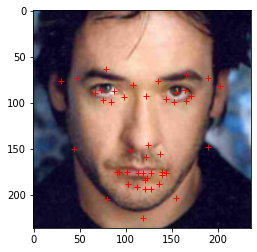

387


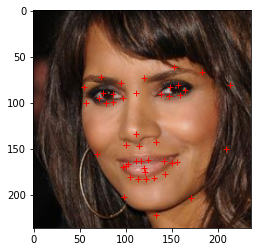

209


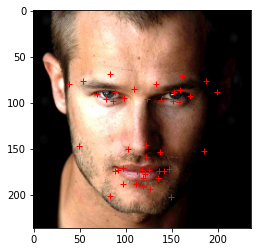

448


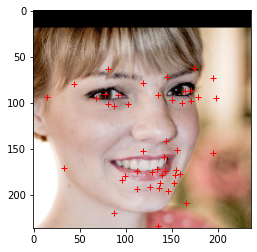

355


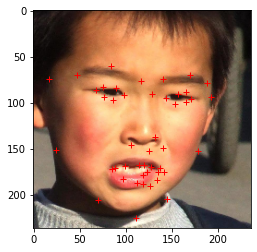

326


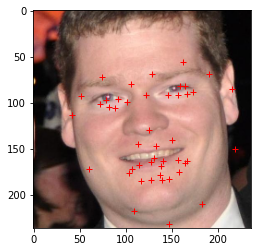

105


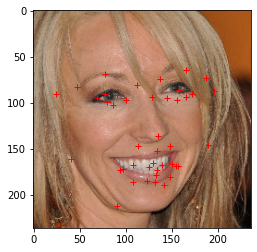

333


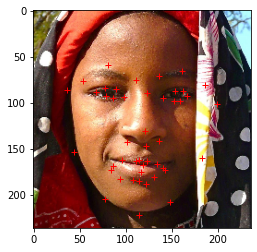

In [ ]:
for i in range(13):
  idx = np.random.randint(0, test_images.shape[0])
  print(idx)
  visualise_pts(test_images[idx], test_points[idx])

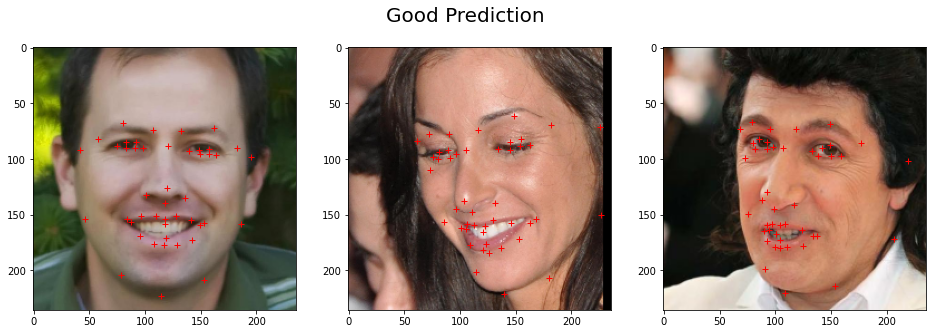

In [ ]:
# plot Good Prediction
plt.figure(figsize=(16,5))
plt.suptitle('Good Prediction', fontsize=20)

plt.subplot(1, 3, 1)
plt.imshow(test_images[223])
plt.plot(test_points[223][:, 0], test_points[223][:, 1], '+r')

plt.subplot(1, 3, 2)
plt.imshow(test_images[454])
plt.plot(test_points[454][:, 0], test_points[454][:, 1], '+r')


plt.subplot(1, 3, 3)
plt.imshow(test_images[15])
plt.plot(test_points[15][:, 0], test_points[15][:, 1], '+r')

plt.show()

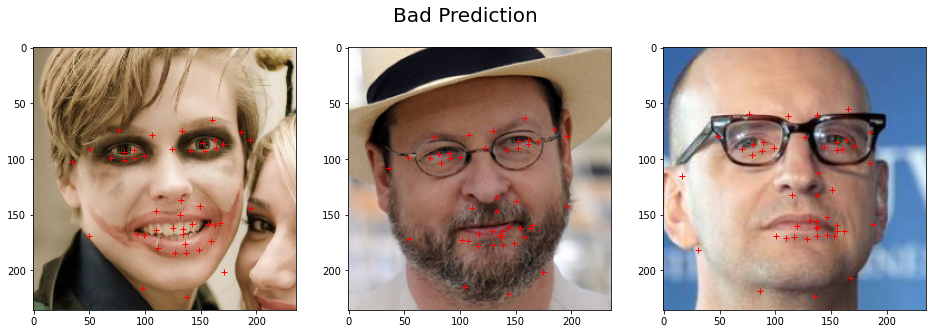

In [ ]:
# plot Good Prediction
plt.figure(figsize=(16,5))
plt.suptitle('Bad Prediction', fontsize=20)

plt.subplot(1, 3, 1)
plt.imshow(test_images[198])
plt.plot(test_points[198][:, 0], test_points[198][:, 1], '+r')

plt.subplot(1, 3, 2)
plt.imshow(test_images[346])
plt.plot(test_points[346][:, 0], test_points[346][:, 1], '+r')


plt.subplot(1, 3, 3)
plt.imshow(test_images[133])
plt.plot(test_points[133][:, 0], test_points[133][:, 1], '+r')

plt.show()

In [ ]:
np.savetxt('/content/drive/My Drive/CV_Assignment/results.csv' , np.reshape(test_points, (test_points.shape[0], -1)), delimiter=',')

## qualitative comparisons

In [8]:
Grayscale_examples = np.zeros(examples.shape[:-1])
for i in range(examples.shape[0]): 
    Grayscale_examples[i] = cv2.cvtColor(examples[i], cv2.COLOR_BGR2GRAY) 

In [9]:
# make test images keypoints prediction
example_points = model.predict(Grayscale_examples.reshape(Grayscale_examples.shape[0], 236, 236, 1))
example_points=example_points.reshape(example_points.shape[0],46,2)

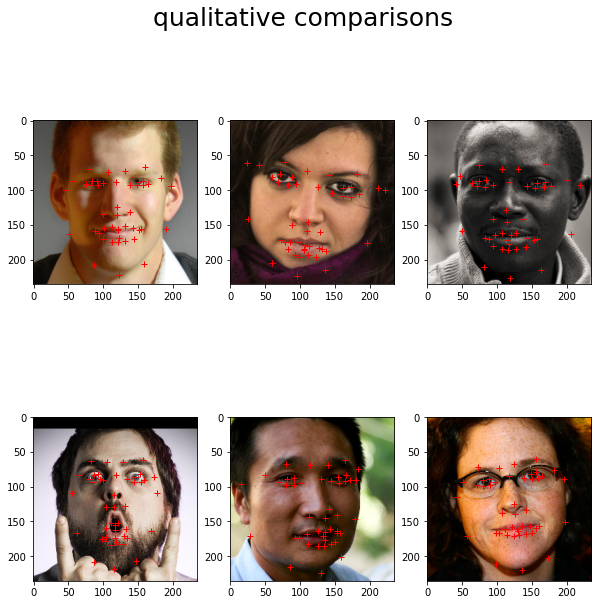

In [10]:
# plot Good Prediction
plt.figure(figsize=(10,10))

plt.suptitle('qualitative comparisons', fontsize=25)
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(examples[i])
  plt.plot(example_points[i][:, 0], example_points[i][:, 1], '+r')
plt.show()

In [13]:
rotated_images = np.zeros(examples.shape,dtype=np.uint32)
rotated_points = np.zeros(example_points.shape, dtype=np.int32)
#do face alignment
for i in range(examples.shape[0]):
  global image,pts
  image=examples[i]
  pts=example_points[i]
  rotated_img, eye_center, angle = align_face(image, pts)
  rotated_pts = rotate_landmarks(pts,eye_center, angle, image.shape[0])
  rotated_images[i]=rotated_img
  rotated_points[i]=rotated_pts

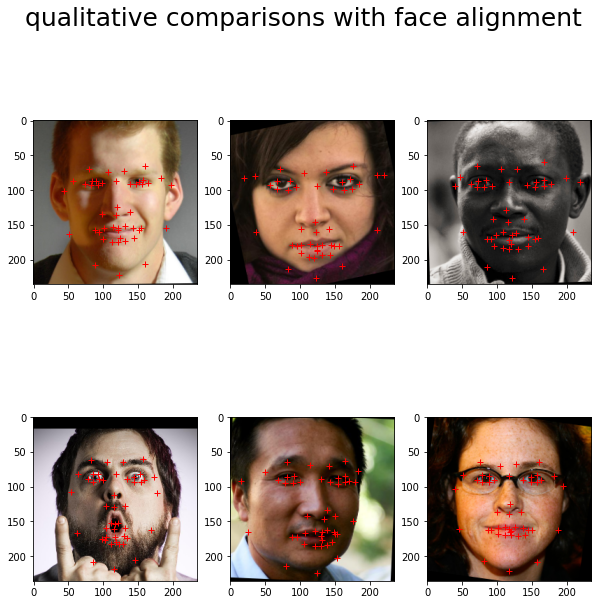

In [14]:
# plot face alignment results
plt.figure(figsize=(10,10))

plt.suptitle('qualitative comparisons with face alignment', fontsize=25)
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(rotated_images[i])
  plt.plot(rotated_points[i][:, 0], rotated_points[i][:, 1], '+r')
plt.show()

#5.2    Face Segmentation

In [11]:
def face_segmentaion (image,pts):
  # make mask and ROI
  masked_image=np.zeros(examples.shape[:-1])
  mask = np.zeros(image.shape, dtype=np.uint8)
  points = np.array([pts[0],pts[1],pts[2],pts[3],pts[4],pts[5],pts[6],pts[12],pts[11],pts[10],pts[13],pts[9],pts[8],pts[7]], dtype=np.int32)
  #roi_corners = np.array([pts[0:13,:]], dtype=np.int32)

  # fill the ROI so it doesn't get wiped out when the mask is applied
  channel_count = image.shape[2]  
  ignore_mask_color = (255,)*channel_count
  cv2.fillPoly(mask, np.int32([points]), ignore_mask_color)

  # apply the mask
  masked_image = cv2.bitwise_and(np.uint8(image), mask)

  #return results
  return masked_image

  # save the result
  #cv2.imwrite('image_masked.png', masked_image)

## fail test

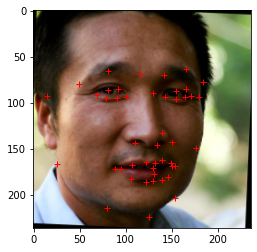

In [17]:
image=rotated_images[4]

pts=rotated_points[4]
plt.imshow(image)
plt.plot(pts[:,0], pts[:,1], '+r')
plt.show()

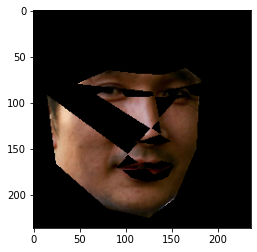

In [ ]:
mask = np.zeros(image.shape, dtype=np.uint8)
roi_corners = np.array([pts], dtype=np.int32)

  # fill the ROI so it doesn't get wiped out when the mask is applied
channel_count = image.shape[2]  
ignore_mask_color = (255,)*channel_count
cv2.fillPoly(mask, roi_corners, ignore_mask_color)

  # apply the mask
masked_image = cv2.bitwise_and(np.uint8(image), mask)

plt.imshow(masked_image)
plt.show()

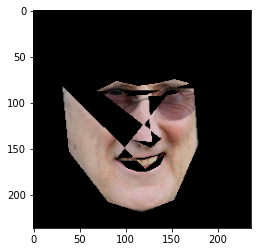

In [ ]:
for i in range(1):
  idx = np.random.randint(0, train_images.shape[0])
  face_segmentaion(train_images[idx, ...], train_points[idx, ...])

## qualitative comparisons

In [15]:
masked_images=np.zeros(examples.shape)
for i in range(6):
  masked_images[i]=face_segmentaion (rotated_images[i], rotated_points[i])

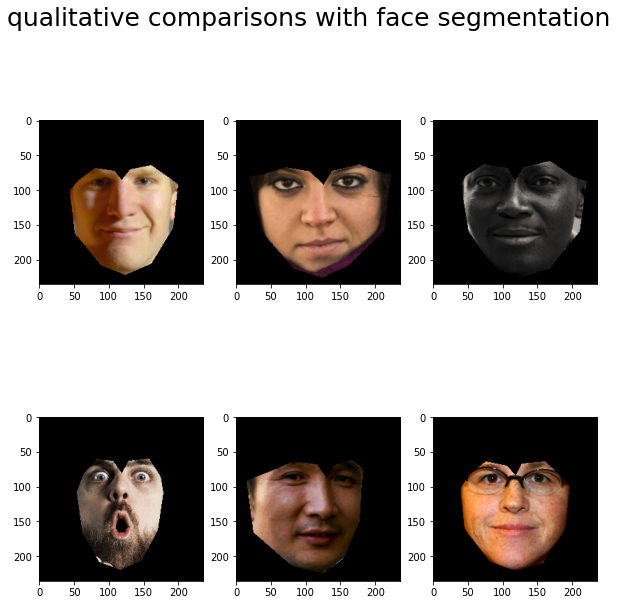

In [16]:
# plot face segmentation results
plt.figure(figsize=(10,10))

plt.suptitle('qualitative comparisons with face segmentation', fontsize=25)
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(masked_images[i].astype('uint8'))
  
plt.show()

# 5.3    Graphical Effects

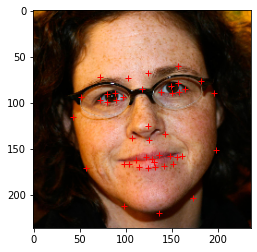

In [40]:
image=examples[5]

pts=example_points[5]
plt.imshow(image)
plt.plot(pts[:,0], pts[:,1], '+r')
plt.show()

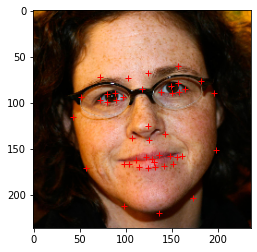

In [41]:
test=image.copy()
plt.imshow(test)
plt.plot(pts[:,0], pts[:,1], '+r')
plt.show()

In [42]:
mouth=pts[30:]

mouth

array([[ 98.07949, 166.44246],
       [111.17683, 161.72205],
       [121.54114, 158.75508],
       [128.74452, 160.30844],
       [136.01314, 156.18669],
       [147.61217, 157.35411],
       [160.84503, 157.23444],
       [150.91714, 166.2857 ],
       [141.14804, 168.52853],
       [131.86482, 169.35486],
       [124.08622, 170.41495],
       [113.9522 , 169.99304],
       [103.38788, 166.57486],
       [130.16942, 164.37614],
       [155.4561 , 159.03052],
       [130.53697, 163.8231 ]], dtype=float32)

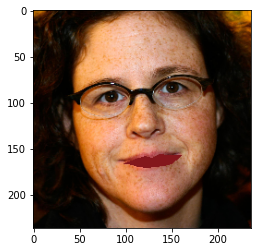

In [43]:
cv2.fillPoly(test,[mouth.astype(int)],(132,23,28))
plt.imshow(test)
plt.show()

## another try

In [ ]:
def sunglasses_graphical_effetcs(image,key_pts):
  # top-left location for sunglasses to go
  # edge of left eyebrow
  x = int(key_pts[0, 0])
  y = int(key_pts[0, 1])

  # height and width of sunglasses
  # h = length of nose
  h = int(abs(key_pts[13,1] - key_pts[14,1]))
  # w = left to right eyebrow edges
  w = int(abs(key_pts[0,0] - key_pts[6,0]))

  # load in sunglasses image with cv2 and IMREAD_UNCHANGED
  sunglasses = cv2.imread('/content/drive/My Drive/CV_Assignment/sunglasses.png', cv2.IMREAD_UNCHANGED)

  # resize our image  
  new_sunglasses=np.zeros(sunglasses.shape)
  new_sunglasses= cv2.resize(sunglasses, (w,h))

  
  # copy of the face image for overlay
  image_copy = np.copy(image)

  # get region of interest on the face to change
  roi_color = image_copy[y:y+h,x:x+w]

  # find all non-transparent pts
  ind = np.argwhere(new_sunglasses[:,:,3] > 0)

  # for each non-transparent point, replace the original image pixel with that of the new_sunglasses
  for i in range(3):
      roi_color[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]    
  # set the area of the image to the changed region with sunglasses
  image_copy[y:y+h,x:x+w] = roi_color


  # return the result
  return image_copy
  #plt.imshow(image_copy)

In [ ]:
graphical_images=np.zeros(rotated_images.shape)
for i in range(6):
  graphical_images[i]=sunglasses_graphical_effetcs(rotated_images[i], rotated_points[i])

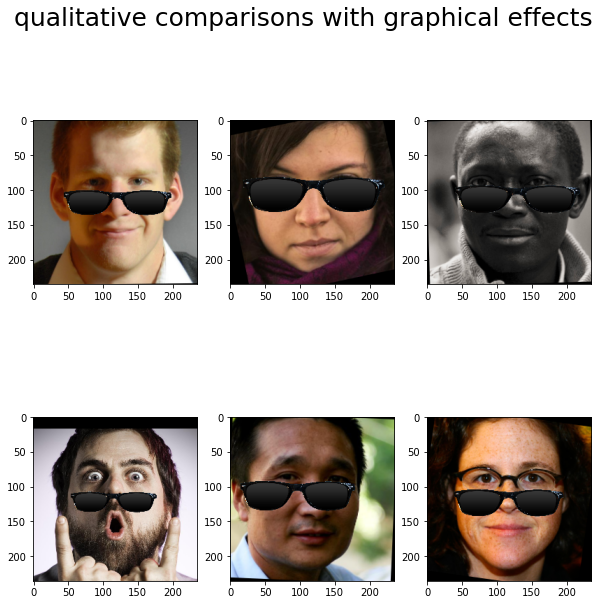

In [ ]:
# plot face alignment results
plt.figure(figsize=(10,10))

plt.suptitle('qualitative comparisons with graphical effects', fontsize=25)
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(graphical_images[i].astype('uint8'))
plt.show()